# Reproducing Nonlinear GPE Dynamics Using a Driven Linear Schrödinger Equation

This project investigates whether the nonlinear dynamics of the discrete Gross–Pitaevskii equation (GPE) in a double-well potential can be reproduced by a *driven linear Schrödinger equation*. The approach extracts optimal time-dependent control fields \(E_t\) from the nonlinear trajectory and then uses these fields to drive the corresponding linear system.

---

## Overview

We consider:

1. **Nonlinear evolution:**  
   The lattice GPE (discrete NLSE)  
   $$
   i\frac{d\psi}{dt} = \left(H_0 + g|\psi|^2\right)\psi,
   $$
   where \(H_0\) is the double-well Hamiltonian and \(g\) controls the nonlinearity.

2. **Control extraction:**  
   Given discrete solutions $\{\psi_t\}$ of the nonlinear GPE, we compute real control amplitudes \(E_t\) by minimizing  
   $$
   \left\|(1 + iH_0 + iV E_t)\psi_t - (1 - iH_0 - iV E_t)\psi_{t-1}\right\|^2,
   $$
   yielding  
   $$
   E_t = -\frac{\Re\langle b_t | a_t \rangle}{\langle b_t | b_t \rangle},
   $$
   with  
   $$
   a_t=(I+i\Delta t\,H_0)\psi_t - (I-i\Delta t\,H_0)\psi_{t-1},  
   $$
   $$
    b_t=i\Delta t\,V(\psi_t+\psi_{t-1}).
   $$
    
4. **Driven linear evolution:**  
   The extracted \(E_t\) drives a linear system:  
   $$
   i\frac{d\phi}{dt} = \left(H_0 + E(t)V\right)\phi,
   $$
   propagated via Crank–Nicolson.

This setup allows direct comparison between nonlinear self-trapping and its linear reconstruction via tailored driving fields.

---

## Features

- 1D lattice GPE solver (RK4 integrator)
- Double-well potential and tunable nonlinearity
- Automatic extraction of optimal real-valued control amplitudes
- Time-dependent Schrödinger solver with Crank–Nicolson
- Comparison tools:
  - Population imbalance (self-trapping diagnostics)
  - Fidelity between nonlinear and driven linear trajectories
  - Final density profile comparison

---

## Running the Simulation

Run the project script:

```
python gpe_driven_linear.py
```

This will:

1. Generate nonlinear GPE dynamics in a double-well  
2. Extract optimal \(E_t\)  
3. Propagate the driven linear system  
4. Produce plots:
   - Left-well population vs. time  
   - Fidelity between nonlinear and linear trajectories  
   - Final density comparison  

---

## Scientific Motivation

The project tests whether **nonlinear many-body mean-field dynamics** (such as self-trapping) can be **effectively emulated** by linear quantum dynamics with a carefully designed time-dependent potential. This connects to:

- Quantum control and GRAPE-like optimization  
- Embedding nonlinearities into enlarged linear systems  
- Information-preserving mappings between nonlinear and linear quantum models

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
J = 1.0          # Hopping amplitude
g = 15.0          # Nonlinearity strength (tune this to enhance self-trapping)
V0 = 1         # Strength of double-well potential
a_dw = 2.0       # Half-distance between wells in the continuous x-coordinate

N = 128          # Number of lattice sites
L = 10.0         # Size of spatial domain (for defining x and potentials)

dt = 0.001        # Time step
n_steps = 40000   # Number of time steps
output_stride = 1  # Store/plot every 'output_stride' steps to reduce memory

## Lattice and Operators

In [3]:
# Lattice positions
xs = np.linspace(-L/2, L/2, N)

# Double-well potential: V_dw(x) = V0 * (x^2 - a^2)^2
V_dw = V0 * (xs**2 - a_dw**2)**2

# Linear potential operator V ~ x (diagonal)
V_lin = np.diag(xs)

# Build tight-binding Hamiltonian H0 for a lattice GPE:
# H0_ij = -J (delta_{i,j+1} + delta_{i,j-1}) + V_dw(i) delta_{i,j}
H0 = np.zeros((N, N), dtype=complex)
for i in range(N):
    H0[i, i] = V_dw[i]
    if i > 0:
        H0[i, i-1] = -J
    if i < N-1:
        H0[i, i+1] = -J

# Identity
I = np.eye(N, dtype=complex)

## Initial State: Localized in Left Well

In [4]:
# Gaussian centered in left well
x0 = -a_dw
sigma = 0.5
psi0 = np.exp(-0.5 * ((xs - x0) / sigma)**2 +20j * xs)
psi0 = psi0.astype(complex)
# Normalize
psi0 /= np.linalg.norm(psi0)

## GPE Time Evolution (Nonlinear)
i dψ/dt = (H0 + g |ψ|^2) ψ

In [5]:
def gpe_rhs(psi):
    """Right-hand side of GPE: dψ/dt = -i (H0 ψ + g |ψ|^2 ψ)"""
    nonlinear_term = g * np.abs(psi)**2 * psi
    return -1j * (H0 @ psi + nonlinear_term)

def rk4_step(psi, dt, rhs_func):
    """One step of RK4 for complex vector ODE."""
    k1 = rhs_func(psi)
    k2 = rhs_func(psi + 0.5 * dt * k1)
    k3 = rhs_func(psi + 0.5 * dt * k2)
    k4 = rhs_func(psi + dt * k3)
    psi_next = psi + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return psi_next

# Allocate storage for nonlinear trajectory (sparse in time)
n_out = n_steps // output_stride + 1
psi_nl_traj = np.zeros((n_out, N), dtype=complex)
times = np.zeros(n_out)

psi = psi0.copy()
psi_nl_traj[0] = psi
times[0] = 0.0

print("Evolving nonlinear GPE ...")
out_idx = 1
for step in range(1, n_steps + 1):
    psi = rk4_step(psi, dt, gpe_rhs)
    # Renormalize to control numerical drift
    psi /= np.linalg.norm(psi)

    if step % output_stride == 0:
        psi_nl_traj[out_idx] = psi
        times[out_idx] = step * dt
        out_idx += 1
print("done")

Evolving nonlinear GPE ...
done


In [6]:
# ==============================
# Compute E_t from {ψ_t} using Crank–Nicolson-like relation
# (1 + i dt H0 + i dt V E_t) ψ_t = (1 - i dt H0 - i dt V E_t) ψ_{t-1}
# -> E_t = -Re(<b_t|a_t>) / <b_t|b_t>, with
#    a_t = (I + i dt H0) ψ_t - (I - i dt H0) ψ_{t-1}
#    b_t = i dt V (ψ_t + ψ_{t-1})
# ==============================
def compute_control_E_t(psi_traj, dt, H0, V_op):
    nT = psi_traj.shape[0]
    E_t = np.zeros(nT, dtype=float)
    for t in range(1, nT):
        psi_t = psi_traj[t]
        psi_tm1 = psi_traj[t-1]
        a_t = (I + 1j*dt*H0) @ psi_t - (I - 1j*dt*H0) @ psi_tm1
        b_t = 1j * dt * (V_op @ (psi_t + psi_tm1))
        num = np.vdot(b_t, a_t)             # <b_t | a_t>
        den = np.vdot(b_t, b_t).real        # <b_t | b_t>, should be real and > 0
        if den > 1e-14:
            E_t[t] = -np.real(num) / den    # real minimizer
        else:
            E_t[t] = 0.0
    return E_t

print("Computing control amplitudes E_t from nonlinear trajectory ...")
E_t = compute_control_E_t(psi_nl_traj, dt * output_stride, H0, V_lin)

Computing control amplitudes E_t from nonlinear trajectory ...


In [7]:
# ==============================
# Driven Linear Schrödinger Evolution
# i dφ/dt = (H0 + E(t) V) φ
# Use Crank–Nicolson with piecewise-constant E(t) ~ E_t
# (I + i dt/2 H(t)) φ_t = (I - i dt/2 H(t)) φ_{t-1}
# Here we evolve on the coarse time grid that matches psi_nl_traj times.
# ==============================
def driven_linear_evolution(phi0, times, E_t, H0, V_op):
    nT = len(times)
    phi_traj = np.zeros((nT, N), dtype=complex)
    phi_traj[0] = phi0
    for t in range(1, nT):
        dt_eff = times[t] - times[t-1]
        E = E_t[t]
        H_eff = H0 + E * V_op
        A = I + 0.5j * dt_eff * H_eff
        B = I - 0.5j * dt_eff * H_eff
        rhs = B @ phi_traj[t-1]
        # Solve A φ_t = B φ_{t-1}
        phi_traj[t] = np.linalg.solve(A, rhs)
        # Optional renormalization for numerical stability
        phi_traj[t] /= np.linalg.norm(phi_traj[t])
    return phi_traj

print("Evolving driven linear Schrödinger equation ...")
phi_lin_traj = driven_linear_evolution(psi0, times, E_t, H0, V_lin)

Evolving driven linear Schrödinger equation ...


In [8]:
# ==============================
# Diagnostics: Self-trapping & Comparison
# ==============================
# Define left/right populations as sums over halves of the lattice
left_sites = xs < 0
right_sites = xs >= 0

P_left_nl = np.sum(np.abs(psi_nl_traj[:, left_sites])**2, axis=1)
P_right_nl = np.sum(np.abs(psi_nl_traj[:, right_sites])**2, axis=1)

P_left_lin = np.sum(np.abs(phi_lin_traj[:, left_sites])**2, axis=1)
P_right_lin = np.sum(np.abs(phi_lin_traj[:, right_sites])**2, axis=1)

# Overlap / distance between nonlinear and driven-linear states
overlaps = np.array([np.vdot(psi_nl_traj[t], phi_lin_traj[t]) for t in range(len(times))])
fidelity = np.abs(overlaps)**2
state_distance = np.array([np.linalg.norm(psi_nl_traj[t] - phi_lin_traj[t]) for t in range(len(times))])


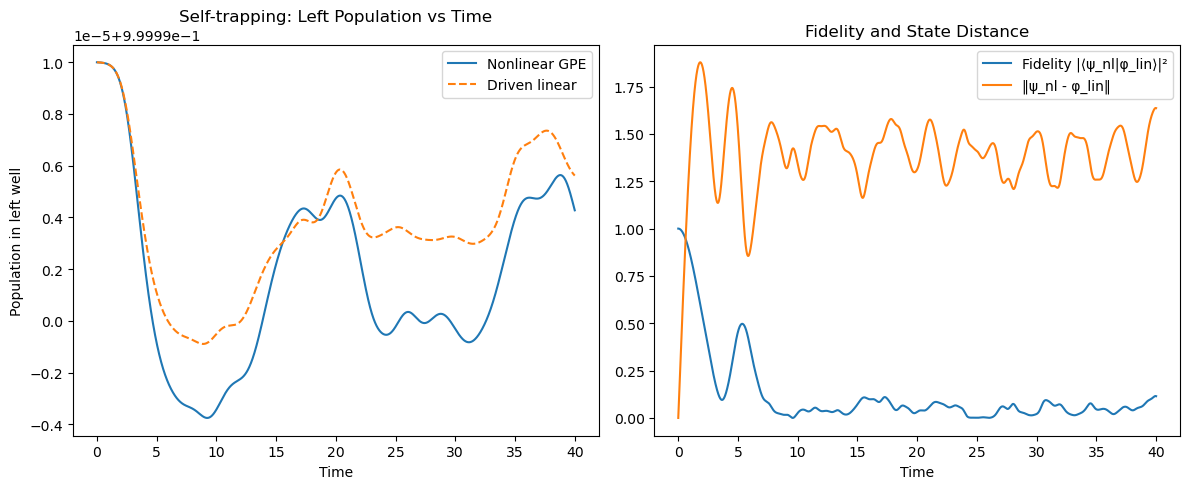

In [9]:
# ==============================
# Plot Results
# ==============================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Self-trapping: Left Population vs Time")
plt.plot(times, P_left_nl, label="Nonlinear GPE")
plt.plot(times, P_left_lin, '--', label="Driven linear")
plt.xlabel("Time")
plt.ylabel("Population in left well")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Fidelity and State Distance")
plt.plot(times, fidelity, label="Fidelity |⟨ψ_nl|φ_lin⟩|²")
plt.plot(times, state_distance, label="‖ψ_nl - φ_lin‖")
plt.xlabel("Time")
plt.legend()

plt.tight_layout()
plt.show()

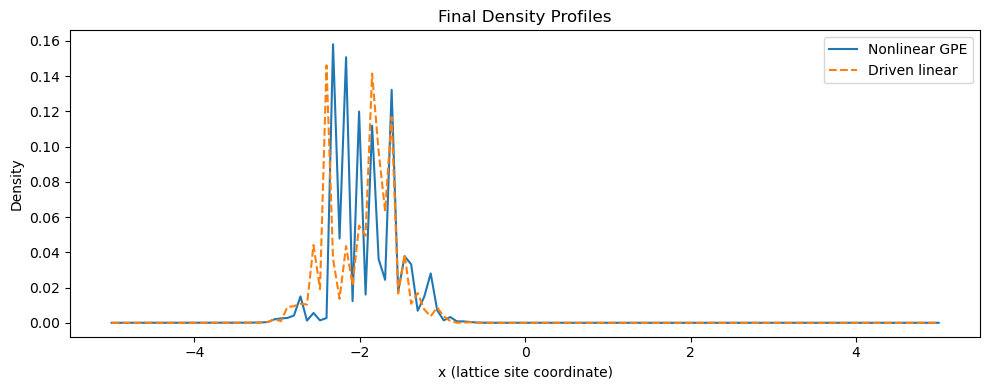

Done. You can inspect self-trapping and the quality of the linear reconstruction in the plots.


In [10]:
# Optional: visualize final density profiles
plt.figure(figsize=(10, 4))
plt.title("Final Density Profiles")
plt.plot(xs, np.abs(psi_nl_traj[-1])**2, label="Nonlinear GPE")
plt.plot(xs, np.abs(phi_lin_traj[-1])**2, '--', label="Driven linear")
plt.xlabel("x (lattice site coordinate)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

print("Done. You can inspect self-trapping and the quality of the linear reconstruction in the plots.")



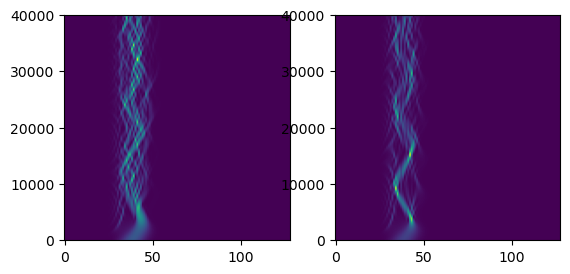

In [11]:
plt.subplot(121)
plt.imshow(
    np.abs(psi_nl_traj)**2,
    aspect=psi_nl_traj.shape[1]/psi_nl_traj.shape[0],
    origin='lower',
)

plt.subplot(122)
plt.imshow(
    np.abs(phi_lin_traj)**2,
    aspect=phi_lin_traj.shape[1]/psi_nl_traj.shape[0],
    origin='lower',
)

plt.show()

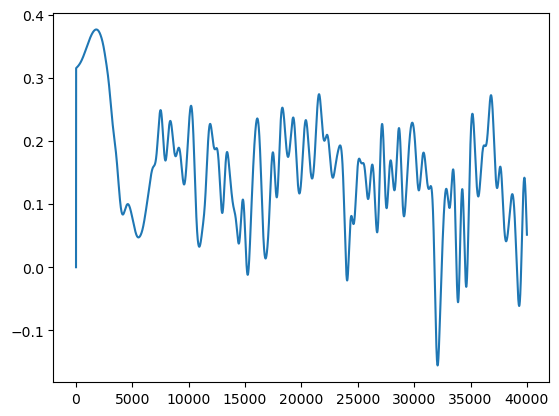

In [12]:
plt.plot(E_t)